In [137]:
import numpy as np
import pandas as pd
from typing import List, Tuple
from scipy.optimize import minimize
from haversine import haversine_vector, Unit
from tqdm import tqdm
from pyproj import Transformer
import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
df = pd.read_csv("data/mappers.csv")
# df = df.drop(["id"], axis=1)

In [139]:
N_HOTSPOTS = 3

In [140]:
# add dummy altitude for now
for hs_idx in range(1, N_HOTSPOTS + 1):
    df[f"hotspot{hs_idx}_altitude"] = 1

In [141]:
# add cartesian coordinate variants
trans_GPS_to_XYZ = Transformer.from_crs("EPSG:4326", "EPSG:4978", always_xy=True)
for hs_idx in range(1, N_HOTSPOTS + 1):
    df[f"hotspot{hs_idx}_x"], df[f"hotspot{hs_idx}_y"], df[f"hotspot{hs_idx}_z"] = trans_GPS_to_XYZ.transform(
        df[f"hotspot{hs_idx}_long"], df[f"hotspot{hs_idx}_lat"], df[f"hotspot{hs_idx}_altitude"]
    )

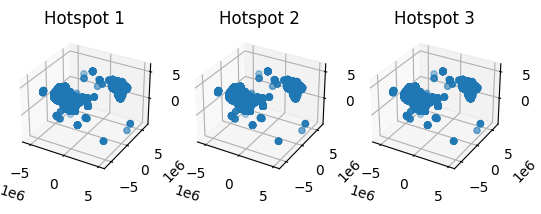

In [142]:
fig = plt.figure()
sub_df = df.sample(n=min(10000, len(df)))
for hs_idx in range(1, N_HOTSPOTS + 1):
    ax = fig.add_subplot(1, N_HOTSPOTS, hs_idx, projection='3d')
    ax.scatter(sub_df[f"hotspot{hs_idx}_x"], sub_df[f"hotspot{hs_idx}_y"], sub_df[f"hotspot{hs_idx}_z"])
    ax.set_title(f"Hotspot {hs_idx}")
plt.show()

In [143]:
# Add fspl distance
def fspl_distance(rssi, frequency_mhz):
    return 10 ** ((np.abs(rssi) - 32.45 - 20 * np.log10(frequency_mhz)) / 20)

for hs_idx in range(1, N_HOTSPOTS + 1):
    df[f"hotspot{hs_idx}_fspl_dist_km"] = fspl_distance(df[f"hotspot{hs_idx}_rssi"], df["frequency"])

In [144]:
# Add a naive tri/lat solve
def tri_lat_solve(distances_to_gateway, gateways_coordinates):
    def error(x, c, r):
        return sum([(np.linalg.norm(x - c[i]) - r[i]) ** 2 for i in range(len(c))])

    l = len(gateways_coordinates)
    S = sum(distances_to_gateway)
    # compute weight vector for initial guess
    W = [((l - 1) * S) / (S - w) for w in distances_to_gateway]
    # get initial guess of point location
    x0 = sum([W[i] * gateways_coordinates[i] for i in range(l)])
    # optimize distance from signal origin to border of spheres
    return minimize(
        error,
        x0,
        args=(gateways_coordinates, distances_to_gateway),
        method="Nelder-Mead",
    ).x


def tri_lat_apply_func(row):
    distances_to_gateway = []
    gateways_coordinates = [] 
    for hs_idx in range(1, N_HOTSPOTS + 1):
        distances_to_gateway.append(row[f"hotspot{hs_idx}_fspl_dist_km"])
        gateways_coordinates.append([
            row[f"hotspot{hs_idx}_x"],row[f"hotspot{hs_idx}_y"],row[f"hotspot{hs_idx}_z"],
        ])
    x,y,z = tri_lat_solve(distances_to_gateway, list(np.array(gateways_coordinates)))
    return [x,y,z]

tqdm.pandas()
df["naive_tri_xyz"] = df.progress_apply(tri_lat_apply_func, axis=1)
df["naive_tri_x"] = df["naive_tri_xyz"].map(lambda x : x[0])
df["naive_tri_y"] = df["naive_tri_xyz"].map(lambda x : x[1])
df["naive_tri_z"] = df["naive_tri_xyz"].map(lambda x : x[2])
df.pop("naive_tri_xyz")

# Calculate the error for the naive trilateration
df["naive_tri_long"], df["naive_tri_lat"], df["naive_tri_alt"] = trans_GPS_to_XYZ.transform(
    df["naive_tri_x"], df["naive_tri_y"], df["naive_tri_z"], direction="INVERSE"
)

labels = df[["latitude", "longitude"]].to_numpy()
naive_pred = df[["naive_tri_lat", "naive_tri_long"]].to_numpy()
df["naive_tri_hav_err_km"] =  haversine_vector(array1=labels, array2=naive_pred, unit=Unit.KILOMETERS)

 12%|█▏        | 898316/7276109 [2:20:01<16:35:11, 106.81it/s]

In [ ]:
plt.hist(df["naive_tri_hav_err_km"], bins=100)
plt.ylabel("# samples")
plt.xlabel("Naive Trilateration Haversine Error (km)")
plt.show()

for q in [0.5, 0.9, 0.99, 0.995, 0.999, 0.9999]:
    km = np.quantile(df["naive_tri_hav_err_km"], q)
    print(f"@ q={q},\t km={km:.2f}km")
# zoom in
plt.figure()
plt.hist(df["naive_tri_hav_err_km"], bins=100)
plt.ylabel("# samples")
plt.xlabel("Naive Trilateration Haversine Error (km)")
plt.xlim(0, np.quantile(df["naive_tri_hav_err_km"], 0.995))
plt.show()


In [ ]:
df.to_csv("data/mappers_processed.csv")